# MTS Generation with COSCI-GAN.


In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from configs.Metric import Metric
from configs.SimulatedData import Proposed
from utils.metric import signature_on_batch, signature_metric
import mlflow
from sklearn.decomposition import PCA
from datetime import datetime
import io
from tensorflow.keras import layers


gpus = tf.config.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs.
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized.
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Load the Data.

In [13]:
config= Proposed()

SEQUENCE_LENGTH = config.sequence_lenght_in_sample
GRANUARITY = config.granularity
OVERLAP = config.overlap
BS = config.batch_size
EPOCHS = 100 #config.epochs
NUM_SEQUENCE_TO_GENERATE = config.met_params.sequence_to_generate
STEP_LIMITATION = 1000
UPDATE_DISCRIMINATOR = 20

SIMULATED_DATA_PATH = "data/simulated_dataset/01 - Source Domain.h5"
SIMULATED_DATA_PATH2= "data/simulated_dataset/output_noise/0.25.h5"

N_SAMPLE_WIENER = SEQUENCE_LENGTH//4
FEAT_WIENER = 2
NOISE_DIM= (N_SAMPLE_WIENER, FEAT_WIENER)
N_STYLE = 2
STYLE_VECTOR = 1

LAMBDA_GLOBAL = 0.001
LAMBDA_LOCAL = 0.001

In [14]:
def convert_dataframe_to_tensorflow_sequences(df:pd.DataFrame, sequence_lenght_in_sample, granularity, shift_between_sequences, batch_size, shuffle=True):
    sequence_lenght = int(sequence_lenght_in_sample*granularity)

    dset = tf.data.Dataset.from_tensor_slices(df.values)
    dset = dset.window(sequence_lenght , shift=shift_between_sequences, stride=granularity).flat_map(lambda x: x.batch(sequence_lenght_in_sample, drop_remainder=True))

    if shuffle:
        dset= dset.shuffle(256)

    dset = dset.batch(batch_size, drop_remainder=True)

    dset = dset.cache().prefetch(10)

    return dset

In [15]:
df_simulated = pd.read_hdf(SIMULATED_DATA_PATH)
df_simulated = df_simulated.drop(columns='labels')

df_simulated2 = pd.read_hdf(SIMULATED_DATA_PATH2)
df_simulated2 = df_simulated2.drop(columns='labels')

dset_simulated = convert_dataframe_to_tensorflow_sequences(
    df_simulated, 
    SEQUENCE_LENGTH, 
    GRANUARITY, 
    int(OVERLAP* SEQUENCE_LENGTH),
    BS
)

dset_simulated2 = convert_dataframe_to_tensorflow_sequences(
    df_simulated2, 
    SEQUENCE_LENGTH, 
    GRANUARITY, 
    int(OVERLAP* SEQUENCE_LENGTH),
    BS
)

dset_simulated = dset_simulated.take(STEP_LIMITATION)
dset_simulated2 = dset_simulated2.take(STEP_LIMITATION)

## Verify if it is correct

2024-06-21 17:09:15.356990: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-21 17:09:15.415723: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


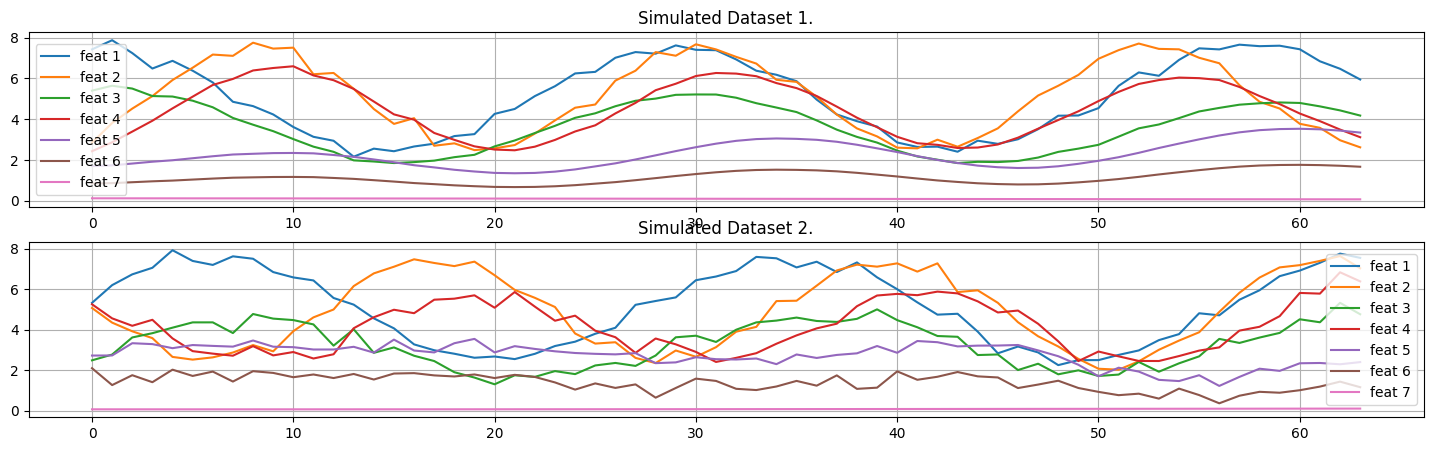

In [16]:
sequence = next(iter(dset_simulated))[0]
sequence2= next(iter(dset_simulated2))[0]

plt.figure(figsize=(18, 5))

ax = plt.subplot(211)
plt.title("Simulated Dataset 1.")
for i in range(sequence.shape[1]):
    plt.plot(sequence[:, i], label=f'feat {i+1}')
plt.grid()
plt.legend()

ax = plt.subplot(212)
ax.set_title("Simulated Dataset 2.")

for i in range(sequence.shape[1]):
    plt.plot(sequence2[:, i], label=f'feat {i+1}')
plt.grid()
plt.legend()

plt.show()

## Make some Wiener Noise.

In [17]:
def wiener_process(batch:int, n_sample_wiener:int, n_feat_wiener:int):
    d_noise = tf.random.normal([batch, n_sample_wiener, n_feat_wiener])
    wiener_noise = tf.math.cumsum(d_noise, axis=1)
    return wiener_noise


seed = wiener_process(NUM_SEQUENCE_TO_GENERATE, N_SAMPLE_WIENER, FEAT_WIENER)


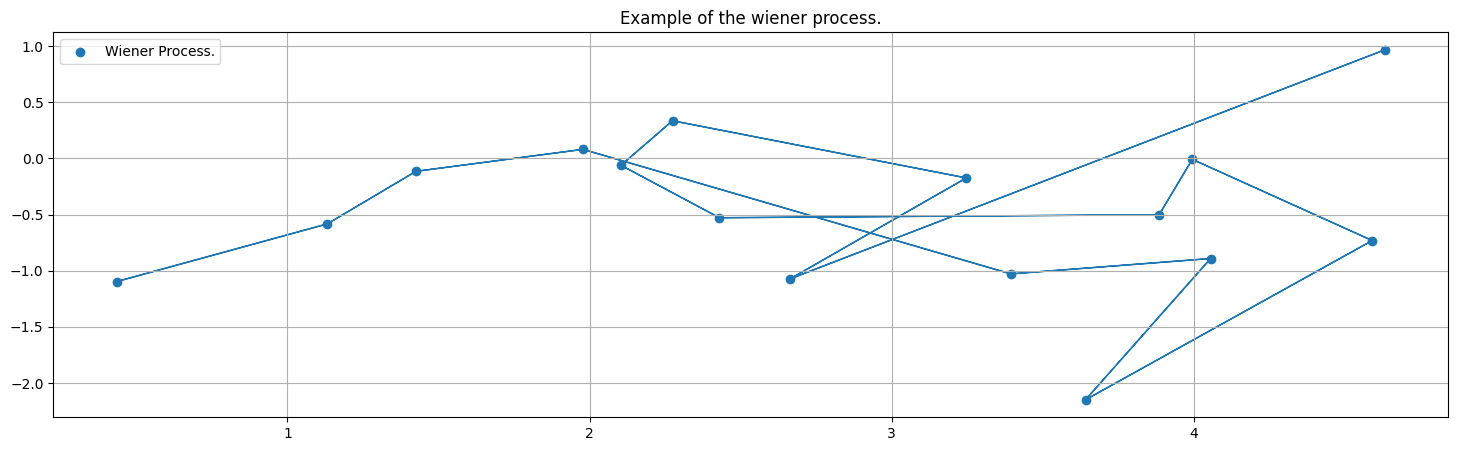

In [18]:
def draw_arrow(A, B, color="b"):
    plt.arrow(A[0], A[1], B[0] - A[0], B[1] - A[1],
              length_includes_head=True, color=color)
    
def draw_arrows(xs, ys, color="b"):
    for i in range(xs.shape[0]-1):
        point0 = [xs[i], ys[i]]
        point1 = [xs[i+1], ys[i+1]]
        draw_arrow(point0, point1, color=color)

plt.figure(figsize=(18, 5))
plt.title("Example of the wiener process.")

draw_arrows(seed[0,:,0], seed[0,:,1], color="tab:blue")
plt.scatter(seed[0,:,0], seed[0,:,1], label='Wiener Process.', color='tab:blue')

plt.grid()
plt.legend()

## Make Model Architectures.

In [19]:
# Define AdaIN Layers for Time Series
class AdaIN(tf.keras.layers.Layer):
    def __init__(self):
        super(AdaIN, self).__init__()

    def get_mean_std(self, x, eps=1e-5):
        _mean, _variance = tf.nn.moments(x, axes=[1], keepdims=True)
        standard_dev = tf.sqrt(_variance+ eps)
        return _mean, standard_dev

    def call(self, content_input, style_input):
        # print(content_input.shape, style_input.shape)
        content_mean, content_std = self.get_mean_std(content_input)
        style_mean, style_std = self.get_mean_std(style_input)
        adain_res =style_std* (content_input - content_mean) / content_std+ style_mean
        return adain_res

In [20]:
def generator_part(content_input, n_sample_wiener:int, feat_wiener:int, style_input:int):
    init = tf.keras.initializers.RandomNormal()

    # Make a small projection...
    _content_input = tf.keras.layers.Flatten()(content_input)
    _content_input = tf.keras.layers.Dense(n_sample_wiener* feat_wiener, kernel_initializer=init)(_content_input)
    _content_input = tf.keras.layers.Reshape((n_sample_wiener, feat_wiener))(_content_input)

    # Make the style input 
    _style_input = tf.keras.layers.Dense(16)(style_input)
    _style_input = tf.keras.layers.Reshape((16, 1))(_style_input)

    x = AdaIN()(_content_input, _style_input)
    x = tf.keras.layers.Conv1DTranspose(256, 5, 2, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1DTranspose(1, 5, 2, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.LeakyReLU()(x)

    return x

def make_generator(n_sample_wiener:int, feat_wiener:int, style_vector_size:int, n_generators:int):
    
    input = tf.keras.Input((n_sample_wiener, feat_wiener), name=f"Content_Input_{i}")
    style_input = tf.keras.Input((style_vector_size,), name="Style_Input") 
    gens_outputs = []

    for _ in range(n_generators):
        gens_outputs.append(generator_part(input, n_sample_wiener, feat_wiener, style_input))


    test = tf.keras.layers.concatenate(gens_outputs, axis=-1)

    model = tf.keras.Model([input, style_input], test)

    return model

In [21]:
def make_global_discriminator(seq_length:int, n_feat:int, n_classes:int):
    _input = tf.keras.Input((seq_length, n_feat))

    x = tf.keras.layers.Conv1D(32, 5, 2, padding='same')(_input)
    x = layers.LeakyReLU()(x)

    x = layers.Flatten()(x)

    _output = layers.Dense(1, activation="sigmoid")(x)
    _class_output = layers.Dense(n_classes, activation="sigmoid")(x)

    model = tf.keras.Model(_input, [_output, _class_output], name="global_discriminator")
    early_predictor = tf.keras.Model(_input, x, name="early_discriminator")

    return model, early_predictor


def local_discriminator_part(_input, n_classes:int):

    x = tf.keras.layers.Conv1D(16, 5, 2, padding='same')(_input)
    x = layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(16, 5, 2, padding='same')(x)
    x = layers.LeakyReLU()(x)

    x = layers.Flatten()(x)
    _output = layers.Dense(1, activation="sigmoid")(x)
    _class_output = layers.Dense(n_classes, activation="sigmoid")(x)

    return _output, _class_output


def create_local_discriminator(n_signals:int, sequence_length:int, n_styles:int):
    sig_inputs = tf.keras.Input((sequence_length, n_signals))
    splited_inputs = tf.split(sig_inputs, n_signals, axis=-1)

    crit_outputs = []
    style_outputs = []

    for sig_input in splited_inputs:
        crit_output, style_output = local_discriminator_part(sig_input, n_styles)
        crit_outputs.append(crit_output)
        style_outputs.append(style_output)

    crit_outputs = tf.keras.layers.concatenate(crit_outputs, axis=-1, name="crit_output")

    model_output = [crit_outputs]
    model_output.extend(style_outputs)

    return tf.keras.Model(sig_inputs, model_output)

In [22]:
generators = make_generator(N_SAMPLE_WIENER, FEAT_WIENER, STYLE_VECTOR, df_simulated.shape[-1])

local_discriminators = create_local_discriminator(df_simulated.shape[-1], SEQUENCE_LENGTH, N_STYLE)

global_discriminator, early_predictor = make_global_discriminator(SEQUENCE_LENGTH, df_simulated.shape[1], N_STYLE)

/home/henri/anaconda3/envs/tf2/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [23]:
tf.keras.utils.plot_model(local_discriminators, show_shapes=True)
# local_discriminators.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 7)]      0           []                               
                                                                                                  
 tf.split_1 (TFOpLambda)        [(None, 64, 1),      0           ['input_3[0][0]']                
                                 (None, 64, 1),                                                   
                                 (None, 64, 1),                                                   
                                 (None, 64, 1),                                                   
                                 (None, 64, 1),                                                   
                                 (None, 64, 1),                                             

### Plot a Sequence.

In [198]:
def generate(content_wp, style, training=True):
    style_labels = tf.zeros((NUM_SEQUENCE_TO_GENERATE, 1))+ style

    signals = generators([content_wp, style_labels])

    # signals = tf.transpose(signals, (1, 2, 0, 3))
    # signals = tf.reshape(signals, signals.shape[:-1])
    return signals

def local_discrimination(sequences, training=True):
    crit = np.array([d(sequences[:, :, i], training=training) for i, d in enumerate(local_discriminators)])
    # crit = tf.transpose(crit, (1, 0, 2))
    return crit

(500, 64, 7)


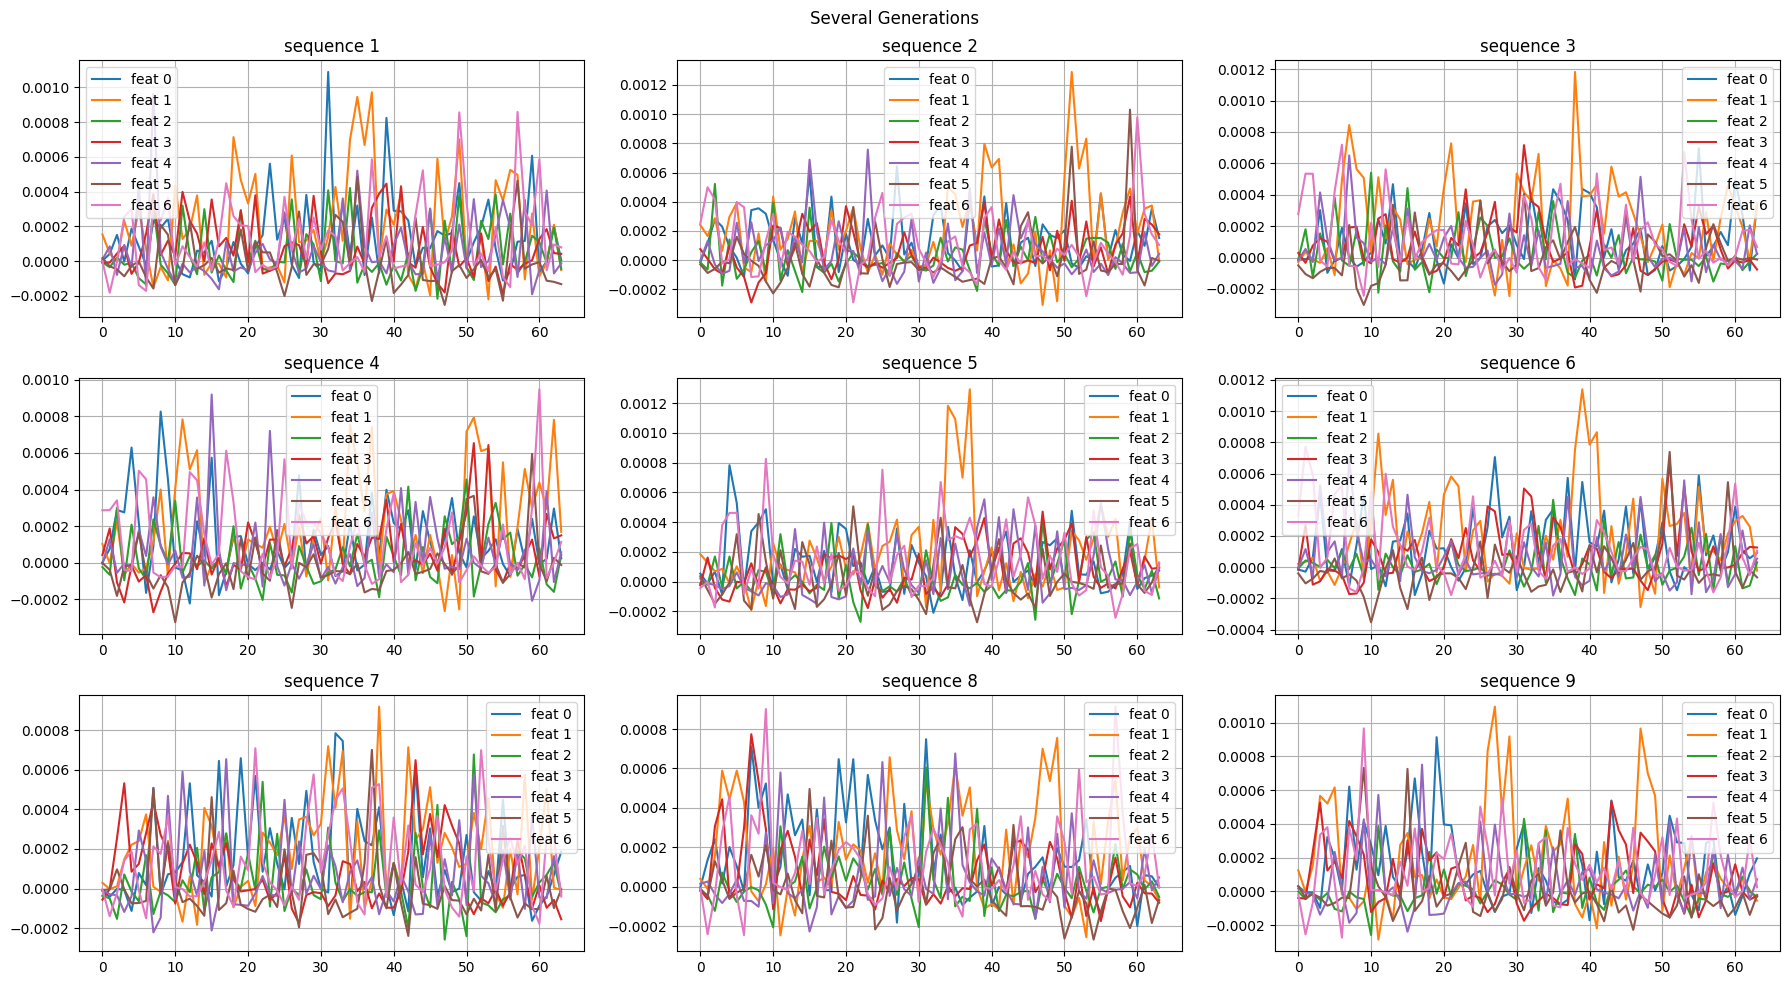

In [200]:
generated = generate(seed, 0.)
print(generated.shape)

# after_training_generations
def plot_several_generations(generations:np.ndarray, nvertical:int=3, nhoriz:int=3):
    legend = [f"feat {j}" for j in range(generations.shape[-1])]

    plt.figure(figsize=(18, 10))
    plt.suptitle("Several Generations")

    for i in range(nvertical* nhoriz):
        ax = plt.subplot(nvertical, nhoriz, i+ 1)
        ax.set_title(f"sequence {i+1}")

        plt.plot(generations[i])
        ax.grid(True)
        plt.legend(legend)

    plt.tight_layout()
    plt.show()

plot_several_generations(generated) 

In [221]:
output = local_discriminators(generated)
crit = output[0]
styles = output[1:]

<tf.Tensor: shape=(500, 7), dtype=float32, numpy=
array([[0.49998915, 0.5000395 , 0.4999987 , ..., 0.50000125, 0.49999803,
        0.49998373],
       [0.50000775, 0.5000336 , 0.5000087 , ..., 0.49998873, 0.4999997 ,
        0.49999785],
       [0.50001734, 0.500043  , 0.5000224 , ..., 0.499996  , 0.5000148 ,
        0.500008  ],
       ...,
       [0.49999428, 0.50005865, 0.4999895 , ..., 0.49999166, 0.50000584,
        0.49999487],
       [0.5000064 , 0.5000261 , 0.5000211 , ..., 0.49999392, 0.50000316,
        0.50000674],
       [0.50002795, 0.5000286 , 0.5000202 , ..., 0.49999714, 0.50002223,
        0.50001216]], dtype=float32)>

## Define losses

In [222]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def similarity_loss(extracted_features:np.ndarray):
    anchor = extracted_features[0]
    return tf.exp(-(tf.norm(extracted_features[1:]- anchor)))

In [223]:
## Generate the reference signature.
real_sequence_style1 = next(iter(dset_simulated))
real_sequence_style2 = next(iter(dset_simulated2))

real_batch_signature_style1= signature_on_batch(real_sequence_style1, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
real_batch_signature_style2= signature_on_batch(real_sequence_style2, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)

2024-06-21 15:16:23.806464: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-21 15:16:23.860544: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [225]:
generator_opt = tf.keras.optimizers.RMSprop(1e-2)
discriminator_opt = tf.keras.optimizers.legacy.RMSprop(2e-3)
global_discriminator_opt = tf.keras.optimizers.RMSprop(2e-3)

# generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-6)    

## Define metrics 

In [226]:
generator_metric = tf.keras.metrics.Mean()
local_discriminator_metric = tf.keras.metrics.Mean()
global_discriminator_metric = tf.keras.metrics.Mean()
similarity_metric = tf.keras.metrics.Mean()

correlation_metric_style1 = tf.keras.metrics.Mean()
correlation_metric_style2 = tf.keras.metrics.Mean()

local_classification_loss = tf.keras.metrics.Mean()
global_classification_loss= tf.keras.metrics.Mean()

## Tensorboard logs.

In [227]:
date_str = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')

BASE_DIR = f"logs - conditional COSCI-GAN/{date_str} - Conditional COSCI-GAN"
TRAIN_LOGS_DIR_PATH = f"{BASE_DIR}/fit"
GENERATION_LOG = f"{BASE_DIR}/Generations"

TRAIN_SUMMARY_WRITER = tf.summary.create_file_writer(TRAIN_LOGS_DIR_PATH)


def plot_to_buff(generation_s1:np.ndarray, generation_s2:np.ndarray, nvertical:int=3, nhoriz:int=3):
    legend = [f"feat {j}" for j in range(generation_s1.shape[-1])]

    fig = plt.figure(figsize=(18, 10))
    plt.suptitle("Generations After GAN Training.")

    for i in range(nvertical* nhoriz):
        current_style = i% 2
        ax = plt.subplot(nvertical, nhoriz, i+ 1)
        if current_style == 0:
            ax.set_title(f"sequence {i+1}. Style 1.")
            plt.plot(generation_s1[i])
        else: 
            ax.set_title(f"sequence {i+1}. Style 2.")
            plt.plot(generation_s2[i])
        ax.grid(True)
        plt.legend(legend)

    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close(fig)
    return buf


def log_losses(epoch, plot_buf):
    image = tf.image.decode_png(plot_buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    with TRAIN_SUMMARY_WRITER.as_default():
        tf.summary.scalar("Generator Loss", generator_metric.result(), step=epoch)

        tf.summary.scalar("Local D loss", local_discriminator_metric.result(), step=epoch)
        tf.summary.scalar("Gobal D loss", global_discriminator_metric.result(), step=epoch)
        
        tf.summary.scalar("Mode Colapsing ?", similarity_metric.result(), step=epoch)
        tf.summary.scalar("Correlation Metric Style 1", correlation_metric_style1.result(), step=epoch)
        tf.summary.scalar("Correlation Metric Style 2", correlation_metric_style2.result(), step=epoch)

        tf.summary.image("Training Generations", image, step=epoch)


# Training Functions

In [228]:
def generate_plots(noise, save_to):
    generated = generate(seed)

    fig =plt.figure(figsize=(18, 5))
    plt.title("Generation of the GAN during Training.")
    for i in range(generated.shape[-1]):
        plt.plot(generated[0, :, i], label=f'feat {i+1}')
    plt.grid()
    plt.legend()

    plt.savefig(save_to)
    plt.close(fig)

In [229]:
bc = tf.keras.losses.BinaryCrossentropy()
error_classif = tf.keras.losses.SparseCategoricalCrossentropy()

def local_discriminator_loss(crits_on_real, crits_on_fake):
    individual_losses = []

    for i in range(crits_on_real.shape[0]):
        l1 = bc(tf.zeros_like(crits_on_real), crits_on_fake[i])
        l2 = bc(tf.ones_like(crits_on_real), crits_on_real[i])
        loss = (l1+ l2)/2
        individual_losses.append(loss)
        
    return individual_losses


def local_generator_loss(crit_on_fake):
    individual_losses = []
    true_label = tf.zeros(crit_on_fake[0].shape)

    for i in range(crit_on_fake.shape[0]):
        individual_losses.append(bc(true_label, crit_on_fake[i]))
        
    return individual_losses

def style_classsification_loss(y_pred, y_true):
    return error_classif(y_true, y_pred)

def global_discriminator_loss(crit_on_real, crit_on_fake):
    l1 = bc(tf.zeros_like(crit_on_fake), crit_on_fake)
    l2 = bc(tf.ones_like(crit_on_real), crit_on_real)
    loss = (l1+ l2)/2

    return loss


def global_generator_loss(crit_on_fake):
    loss = bc(tf.ones_like(crit_on_fake), crit_on_fake)
    return loss

In [230]:
def make_local_predictions(sequences, training=True):
    _crit_classif = []
    _crit_styles = []

    for i in range(len(local_discriminators)):
        crit, styles = local_discriminators[i](sequences[:,:, i], training=training)
        _crit_classif.append(crit)
        _crit_styles.append(styles)

    return np.array(_crit_classif), np.array(_crit_styles)

In [244]:
@tf.function
def discriminators_step(style1_ts, style2_ts, generators_, local_discriminators_, global_discriminator_):
    noise= wiener_process(BS, N_SAMPLE_WIENER, FEAT_WIENER)
    style_labels = tf.zeros((BS,))

    with tf.GradientTape(persistent=True) as d_tape:
        style1_generated = generators_([noise, style_labels], training=False)
        style2_generated = generators_([noise, style_labels+ 1.], training=False)

        local_gen1 = local_discriminators_(style1_generated, training=True)
        local_g1_crit = local_gen1[0]  #We DO NOT care about style of generation of the discriminator step.

        local_gen2 = local_discriminators_(style2_generated, training=True)
        local_g2_crit = local_gen2[0] #We DO NOT care about style of generation of the discriminator step.

        local_real1 = local_discriminators_(style1_ts, training=True)
        local_r1_crit, local_r1_styles = local_real1[0], local_real1[1:]

        local_real2 = local_discriminators_(style2_ts, training=True)
        local_r2_crit, local_r2_styles =  local_real2[0], local_real2[1:]

        g_crit_gen1, _ = global_discriminator_(style1_generated, training=True)
        g_crit_gen2, _ = global_discriminator_(style2_generated, training=True)

        g_crit_real1, g_style_real1= global_discriminator_(style1_ts, training=True)
        g_crit_real2, g_style_real2= global_discriminator_(style2_ts, training=True)

        # (LOCAL DISCRIMINATOR) Real / Fake Loss 
        local_d_losses1 = local_discriminator_loss(local_g1_crit, local_r1_crit)
        local_d_losses2 = local_discriminator_loss(local_g2_crit, local_r2_crit)
        local_d_losses = local_d_losses1 + local_d_losses2

        #(LOCAL DISCRIMINATOR) Style CLassification:
        style_labels = tf.zeros((BS, 1))
        local_s1_loss = [style_classsification_loss(local_r1_styles[i], style_labels) for i in range(style1_ts.shape[-1])]
        local_s2_loss = [style_classsification_loss(local_r2_styles[i], style_labels+ 1.) for i in range(style1_ts.shape[-1])]
        local_style_loss = local_s1_loss + local_s2_loss
        local_style_loss.insert(0, local_d_losses)

        # (GLOBAL DISCRIMINATOR) Real/ Fake Loss
        global_d_loss1 = global_discriminator_loss(g_crit_real1, g_crit_gen1)
        global_d_loss2 = global_discriminator_loss(g_crit_real2, g_crit_gen2)
        global_discrimination_loss = global_d_loss1+ global_d_loss2

        # (GLOBAL DISCRIMINATOR) Style Classification
        global_classif1 = style_classsification_loss(g_style_real1, style_labels)
        global_classif2 = style_classsification_loss(g_style_real2, style_labels+ 1.)
        global_style_loss = global_classif1+ global_classif2

    # start = datetime.now()
    # (GOBAL DISCRIMINATOR): Real / Fake and style
    global_discr_gradient = d_tape.gradient([global_discrimination_loss, global_style_loss], global_discriminator_.trainable_variables)
    global_discriminator_opt.apply_gradients(zip(global_discr_gradient, global_discriminator_.trainable_variables)) 
    
    grads = d_tape.gradient(local_style_loss, local_discriminators_.trainable_variables)
    discriminator_opt.apply_gradients(zip(grads, local_discriminators_.trainable_variables))

    local_discriminator_metric(tf.reduce_mean(local_d_losses))
    global_discriminator_metric(global_discrimination_loss)
    # print(" - ", datetime.now() - start)
    
@tf.function
def generator_step(generators_, local_discriminators_, _global_discriminator):
    noise= wiener_process(BS, N_SAMPLE_WIENER, FEAT_WIENER)
    style_labels = tf.zeros((BS,))
    
    with tf.GradientTape(persistent=True) as g_tape:
        style1_generated = generators_([noise, style_labels], training=False)
        style2_generated = generators_([noise, style_labels+ 1.], training=False)

        # (LOCAL DISCRIMINATOR): Fakeness Predictions
        local_gen1 = local_discriminators_(style1_generated, training=True)
        local_d1_crit, local_d1_styles =  local_gen1[0], local_gen1[1:]

        local_gen2 = local_discriminators_(style2_generated, training=True)
        local_d2_crit, local_d2_styles =  local_gen2[0], local_gen2[1:]

        # (GLOBAL DISCRIMINATOR): Predictions.
        g_crit_gen1, g_style1 = _global_discriminator(style1_generated, training=False)
        g_crit_gen2, g_style2 = _global_discriminator(style2_generated, training=False)

        # (LOCAL DISCRIMINATOR): Real/ Fake.
        local_g_loss1 = local_generator_loss(local_d1_crit)
        local_g_loss2 = local_generator_loss(local_d2_crit)
        local_g_loss = local_g_loss1+ local_g_loss2

        # (LOCAL DISCRIMINATOR): Style.
        style_labels = tf.zeros((BS, 1))
        local_s1_loss = tf.convert_to_tensor([style_classsification_loss(local_d1_styles[i], style_labels) for i in range(style1_generated.shape[-1])])
        local_s2_loss = tf.convert_to_tensor([style_classsification_loss(local_d2_styles[i], style_labels+ 1.) for i in range(style1_generated.shape[-1])])
        local_style_preservation = tf.reduce_mean(local_s1_loss + local_s2_loss)

        # (GLOBAL DISCRIMINATOR): Real / Fake.
        global_g_loss1= global_generator_loss(g_crit_gen1)
        global_g_loss2= global_generator_loss(g_crit_gen2)
        global_g_loss = global_g_loss1+ global_g_loss2

        # (GLOBAL DISCRIMINATOR): Style Classification.
        global_style1_preservation = style_classsification_loss(g_style1, style_labels)
        global_style2_preservation = style_classsification_loss(g_style2, style_labels+ 1.)
        global_style_preservation = global_style1_preservation + global_style2_preservation

        g_loss = LAMBDA_GLOBAL* (global_g_loss+ global_style_preservation)+ LAMBDA_LOCAL* (local_g_loss+ local_style_preservation)
        
    grads = g_tape.gradient(g_loss, generators.trainable_variables)
    generator_opt.apply_gradients(zip(grads, generators.trainable_variables))

    generator_metric(tf.reduce_mean(local_g_loss))

In [245]:
def train(dataset1, dataset2, epochs):
  losses = []
  total_steps = "?"
  for epoch in range(epochs):
    start = time.time()

    generator_metric.reset_states()
    global_discriminator_metric.reset_states()
    local_discriminator_metric.reset_states()

    for s, (sequence1, sequence2) in enumerate(zip(dataset1, dataset2)):
      if s % UPDATE_DISCRIMINATOR == 0:
        discriminators_step(sequence1, sequence2, generators, local_discriminators, global_discriminator)
        
      generator_step(generators, local_discriminators, global_discriminator)

      print(f"\r e {epoch}/{epochs}, s {s}/{total_steps}: Gen {generator_metric.result():0.4f}; Global discriminator: {global_discriminator_metric.result():0.4f}; Local discriminator: {local_discriminator_metric.result():0.4f}; Sim loss: {similarity_metric.result():0.4f}", end="")
      # break
    if epoch == 0:
      total_steps = s

    # stop = time.time()
    # print()
    # print(f"\r[+] Epoch {epoch}/{epochs} in {(stop-start):0.4f} seconds. ({(stop-start)/total_steps:0.4f} s/step)")

    # generate_plots(seed, f"imgs/GAN_generations/{epoch}.png")
    # Make generations on seed
    seed_generation1 = generate(seed, 0., training=False)
    seed_generation2 = generate(seed, 1., training=False)
    buff = plot_to_buff(seed_generation1, seed_generation2)

    batch_signature_style1 = signature_on_batch(seed_generation1, [0, 1], [2, 3, 4, 5], config.met_params.signature_length)
    signature_difference1 = signature_metric(real_batch_signature_style1, batch_signature_style1)

    batch_signature_style2 = signature_on_batch(seed_generation2, [0, 1], [2, 3, 4, 5], config.met_params.signature_length)
    signature_difference2 = signature_metric(real_batch_signature_style2, batch_signature_style2)

    correlation_metric_style1(signature_difference1)
    correlation_metric_style2(signature_difference2)

    l = [generator_metric.result(), global_discriminator_metric.result(), local_discriminator_metric.result()]
    losses.append(l)
    log_losses(epoch, buff)

  return np.array(losses)

In [246]:
training_losses = train(dset_simulated, dset_simulated2, EPOCHS)

 e 0/50, s 151/?: Gen 0.0033; Global discriminator: 0.0000; Local discriminator: 0.0000; Sim loss: 0.0000

2024-06-21 15:47:44.276323: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-21 15:47:44.281836: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


KeyboardInterrupt: 

## Plot Losses.

In [ ]:
plt.figure(figsize=(18, 5))
plt.title("Training Losses.")
plt.plot(training_losses[:, 0], ".-", label="Generator Loss")
plt.plot(training_losses[:, 1], ".-", label="Discriminator Loss")
plt.grid()
plt.legend()
plt.show()

# Let's Test it!

In [ ]:
after_training_generations = generator(seed, training=False)

plt.figure(figsize=(18, 5))
plt.title("Generation of the GAN whitout Training.")
for i in range(after_training_generations.shape[-1]):
    plt.plot(after_training_generations[0, :, i], label=f'feat {i+1}')
plt.grid()
plt.legend()
plt.show()

In [ ]:
after_training_decision = discriminator(after_training_generations)
after_training_decision[0]

## Test if Mode Colapsing

In [ ]:
# after_training_generations
def plot_several_generations(generations:np.ndarray, nvertical:int=3, nhoriz:int=3):

    legend = [f"feat {j}" for j in range(generations.shape[-1])]

    plt.figure(figsize=(18, 10))
    plt.suptitle("Generations After GAN Training.")

    for i in range(nvertical* nhoriz):
        ax = plt.subplot(nvertical, nhoriz, i+ 1)
        ax.set_title(f"sequence {i+1}")

        plt.plot(generations[i])
        ax.grid(True)
        plt.legend(legend)

    plt.tight_layout()
    plt.show()

plot_several_generations(after_training_generations)